# Car Crashes
In this Jupyter Notebook, we will examine the number of car crashes that occured in each neighborhood in the City of Pittsburgh during 2020. We will be using two datasets from the WPRDC: **Pittsburgh Neighborhoods** and **Allegheny County Crash Data**. Use the code block below to load them from the WPRDC website.

In [2]:
#Imports pandas, geopandas, and matplotlib
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

#Takes a GeoJSON of all neighborhoods in City of Pittsburgh and turns it into a GeoDataFrame indexed by neighborhood
neighborhood_url = "https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/4af8e160-57e9-4ebf-a501-76ca1b42fc99/download/pittsburghpaneighborhoods-.geojson"
neighborhood_gdf = geopandas.read_file(neighborhood_url).set_index('hood')

#Takes a CSV of all reported crashes in Allegheny County from 2017 to 2020 and turns it into a GeoDataFrame of Points
crashes_df = pd.read_csv("crashes.csv", low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])
crashes_mask = (crashes_df['CRASH_YEAR'] >= 2017) & (crashes_df['CRASH_YEAR'] <= 2020)
crashes_4 = crashes_df[crashes_mask]
crashes_gdf = geopandas.GeoDataFrame(crashes_4, geometry=geopandas.points_from_xy(crashes_4.DEC_LONG, crashes_4.DEC_LAT, crs=4326))

#Correcting for some oddities in neighborhoods data where sqmiles is plain wrong for select neighborhoods
neighborhood_gdf.at['Perry North','sqmiles'] = 1.212
neighborhood_gdf.at['Lincoln-Lemington-Belmar','sqmiles'] = 1.812
neighborhood_gdf.at['Marshall-Shadeland','sqmiles'] = 1.254

## Reformatting the Data
Unfortunately, the car crashes data set does not have a neighborhood associated with each car crash, which means we'll have to use the latitude and longitude of each incident and the geometry of the neighborhoods to figure out which neighborhood each crash took place in, if any. The code block below assigns car crashes to neighborhoods and counts the number of car crashes per neighborhood.

In [3]:
#New pittsburgh_crashes GeoDataFrame contains all crashes in any Pittsburgh neighborhood with a column for neighborhood
#Also adds a column to the neighborhood_gdf for the number of crashes in each neighborhood
pittsburgh_crashes = geopandas.GeoDataFrame(columns=crashes_gdf.columns.append(pd.Index(['hood'])), geometry='geometry', crs=4326)
crash_count = []
for i in neighborhood_gdf.index:
    bool_crashes = crashes_gdf.within(neighborhood_gdf.loc[i].geometry)
    try:
        count = bool_crashes.value_counts().loc[True]
    except KeyError:
        count = 0
    crash_count.append(count)
    neighborhood_crashes = crashes_gdf[bool_crashes].assign(hood=i)
    pittsburgh_crashes = pd.concat([neighborhood_crashes, pittsburgh_crashes])
try:
    neighborhood_gdf.insert(0, "crashes", pd.to_numeric(pd.Series(crash_count, index=neighborhood_gdf.index)))
except ValueError:
    neighborhood_gdf['crashes'] = pd.to_numeric(pd.Series(crash_count, index=neighborhood_gdf.index))

## Checking Our Code
As that's a fair amount of unintuitive code above, we should probably check that it works. To do this we, can plot the data set of crashes in Allegheny County and our subset of crashes in the City of Pittsburgh.

(40.1, 40.7)

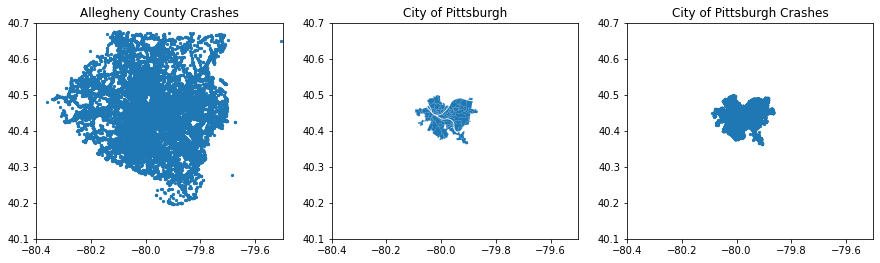

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

#Creates subplot of all crashes in Allegheny County in 2020 with crashes_gdf
crashes_gdf.plot(ax=axes[0], markersize=5)
axes[0].set_title('Allegheny County Crashes')
axes[0].set_xlim(-80.4, -79.5)
axes[0].set_ylim(40.1,40.7)

#Creates subplot of the neighborhoods of the City of Pittsburgh with neighborhood_gdf
neighborhood_gdf.plot(ax=axes[1])
axes[1].set_title('City of Pittsburgh')
axes[1].set_xlim(-80.4, -79.5)
axes[1].set_ylim(40.1,40.7)

#Creates a subplot of all crashes in the City of Pittsburgh in 2020 with pittsburgh_crashes
pittsburgh_crashes.plot(ax=axes[2], markersize=5)
axes[2].set_title('City of Pittsburgh Crashes')
axes[2].set_xlim(-80.4, -79.5)
axes[2].set_ylim(40.1,40.7)

As we can see above, the Allegheny County Crashes plot clearly resembles Allegheny County (with the exception of one oddball point) while the City of Pittsburgh Crashes plot takes the size and shape of the city.

## The Metric
While most of our work is done, we need a better metric to discover which neighborhood is the best to live in, as the sheer number of car crashes is largely affected by the area of the neighborhood. We'll be using the crashes per square mile metric. This should be pretty easy to find as we already have both the number of crashes in and the area of each neighborhood. The below code finds that metric for each neighborhood and plots the data.

(-80.10681505991923, -79.85429464126214, 40.354642646539126, 40.50793371245118)

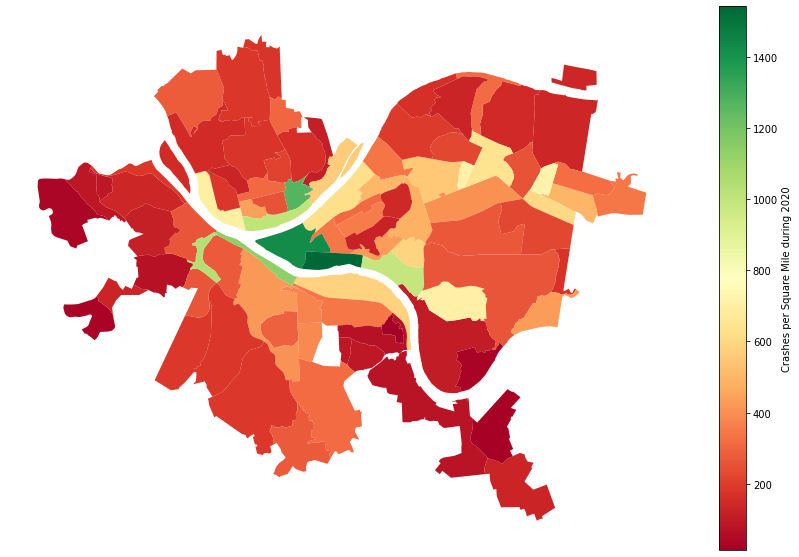

In [6]:
#Adds a column for crashes per square mile to neighborhood_gdf and plots it
neighborhood_gdf = neighborhood_gdf.assign(crash_sqmile = lambda x: x['crashes'] / x['sqmiles'])
neighborhood_gdf.plot(column='crash_sqmile',
                      cmap="RdYlGn",
                      legend=True,
                      legend_kwds={'label':'Crashes per Square Mile during 2020'},
                      figsize=(15,10))
plt.axis('off')

## Rankings
Now it's time to rank the neighborhoods of Pittsburgh by crashes per square mile!

In [11]:
total=list(neighborhood_gdf[['crashes','sqmiles']].sum())
print("The neighborhoods of Pittsburgh as a whole averaged " + str(int(total[0]/total[1])) + " crashes per square mile from 2016 through 2020.")
print("Let's see how each neighborhood contributed.\n")

sort_items = list(neighborhood_gdf.sort_values('crash_sqmile', ascending=False)['crash_sqmile'].items())
for i in range(len(sort_items)):
    pair = sort_items[i]
    print(str(i+1) + ". " + pair[0] + " - " + str(int(pair[1])))

The neighborhoods of Pittsburgh as a whole averaged 297 crashes per square mile from 2016 through 2020.
Let's see how each neighborhood contributed.

1. Bluff - 1541
2. Central Business District - 1426
3. East Allegheny - 1271
4. South Shore - 1141
5. West End - 1035
6. North Shore - 1006
7. South Oakland - 988
8. Homewood West - 713
9. Friendship - 707
10. Greenfield - 701
11. Chateau - 697
12. East Liberty - 645
13. Strip District - 623
14. Point Breeze North - 604
15. Central Oakland - 590
16. South Side Flats - 584
17. Troy Hill - 567
18. Bloomfield - 554
19. Polish Hill - 501
20. Homewood South - 492
21. North Oakland - 484
22. Allegheny West - 439
23. Swisshelm Park - 437
24. West Oakland - 437
25. Mount Washington - 423
26. Bon Air - 408
27. Shadyside - 402
28. Knoxville - 387
29. Allentown - 372
30. Middle Hill - 360
31. Crawford-Roberts - 348
32. East Hills - 347
33. South Side Slopes - 346
34. Lower Lawrenceville - 337
35. Homewood North - 324
36. Carrick - 317
37. Morningsid

## Conclusion
The Bluff is the best neighborhood for car crashes, which makes sense as Forbes, Fifth, the Boulevard of the Allies, and the Penn-Licoln Parkway all run through it's relatively small area.